In [7]:
import os
import imp
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import sys
import pickle as plk
import importlib.util
from IPython.display import display, Math

###############################################################
#LINUX PATH

sys.path.append("/opt/lumerical/v221/api/python") #Default linux lumapi path
import lumapi
sys.path.append(os.path.dirname('/media/leonardo/datam02/Ring Resonator - Leonardo Pessôa/Ring-Resonator/Tutorial/')) #Current directory

###############################################################
# WINDOWS PATH

# spec_win = importlib.util.spec_from_file_location('lumapi', 'C:\\Program Files\\Lumerical\\v202\\api\\python\\lumapi.py')
# lumapi = importlib.util.module_from_spec(spec_win)
# os.add_dll_directory("C:/Program Files/Lumerical/v202/api/python")
# sys.path.append(os.path.dirname('D:/AAAAAAAArquivos/Facul/Capacitação/GitHub/Ring-Resonator'))
# spec_win.loader.exec_module(lumapi)



In [3]:
Cband = np.linspace(1.530e-6, 1.565e-6, 2000)
band = np.linspace(1500e-9, 1600e-9, 2000)
c0 = 299792458

# Lumerical FDTD

In [4]:
fdtd = lumapi.FDTD(filename='ring_resonator.fsp')

In [16]:
fdtd.switchtolayout()
fdtd.selectall() 
fdtd.delete()

mesh =   0.01e-6
r =      3e-6
width =  0.4e-6
height = 0.18e-6
lc =     0e-6
gap =    150e-9

material   = 'Si (Silicon) - Palik'
background = 'SiO2 (Glass) - Palik'

fdtd.addfdtd()
fdtd.set({
  'x'                         : 0,
  'x span'                    : 14e-6,
  'y'                         : 0,
  'y span'                    : 3*r,
  'z'                         : height/2,
  'z span'                    : 2e-6,
  'background material'       : background,
  'mesh accuracy'             : 3,
  'Z min bc'                  : 'Symmetric',
  'set simulation bandwidth'  : 1,
  'simulation wavelength min' : 1.5e-6,
  'simulation wavelength max' : 1.6e-6,
  'simulation time'           : 3e-12
})

fdtd.addobject('ring_resonator')
fdtd.set({
    'x'           : -7e-6,
    'y'           : 0,
    'z'           : height/2,
    'gap'         : gap,
    'radius'      : r,
    'base width'  : width,
    'base height' : height,
    'base angle'  : 90,
    'material'    : material,
    'name'        : 'Ring Resonator',
    'x span'      : 14e-6,
    'lc'          : lc
      })

fdtd.addport()
fdtd.set({
  'x'      : -1.25*r,
  'z'      : height/2,
  'y'      : r + gap + width,
  'y span' : 2e-6,
  'z span' : 1.5e-6,
})

fdtd.addport()
fdtd.set({
  'x'         : 1.25*r,
  'z'         : height/2,
  'y'         : r + gap + width,
  'y span'    : 2e-6,
  'z span'    : 1.5e-6,
  'direction' :'Backward'
})

fdtd.addport()
fdtd.set({
  'x'      : -1.25*r,
  'z'      : height/2,
  'y'      : -(r + gap + width),
  'y span' : 2e-6,
  'z span' : 1.5e-6,
})

fdtd.addport()
fdtd.set({
  'x'         : 1.25*r,
  'z'         : height/2,
  'y'         : -(r + gap + width),
  'y span'    : 2e-6,
  'z span'    : 1.5e-6,
  'direction' :'Backward'
})

Lc Sweep with an straight waveguide 

In [17]:
# Guide modifications for the sweep

fdtd.addrect()
fdtd.set({
  'name'      : 'Extension 1',
  'x min'     : r -(width/2) + lc/2,
  'x max'     : r +(width/2) + lc/2,
  'y max'     : 0,
  'y min'     : -r,
  'z min'     : 0,
  'z max'     : height,
  'material'  : material,
})

fdtd.addrect()
fdtd.set({
  'name'     : 'Extension 2',
  'x min'    : -(r +(width/2) + lc/2),
  'x max'    : -(r -(width/2) + lc/2),
  'y max'    : 0,
  'y min'    : -r,
  'z min'    : 0,
  'z max'    : height,
  'material' : material,
})

fdtd.setnamed('Ring Resonator::outer_bottom',{'enabled' :  0,})

fdtd.setnamed('Ring Resonator::arc2',{'enabled' :  0,})

fdtd.setnamed('Ring Resonator::arc3',{'enabled' :  0,})

fdtd.setnamed('FDTD', {
    'x' : 0,
    'x span' : 14e-6,
    'y' : r/2,
    'y span' : 2*r,
    'z' : height/2,
})

fdtd.setnamed('FDTD::ports::port 2',{
  'y' : r+gap+width,
  'x' : 2*r,
  'z' : height/2
})

fdtd.setnamed('FDTD::ports::port 1',{'x' : -2*r})

fdtd.setnamed('FDTD::ports::port 3',{
  'y' : -1e-6,
  'injection axis' : 'y-axis',
  'x' : r,
  'x span' : 2e-6,
  'z' : height/2,
})

fdtd.setnamed('FDTD::ports::port 4',{
  'y' : -1e-6,
  'injection axis' : 'y-axis',
  'x' : -(r + lc/2),
  'x span' : 2e-6,
  'z' : height/2,
  'direction' :'Forward'
})

In [ ]:
#Plots

figure14,fig = plt.subplots(1, 2, figsize=(20,10))

values = np.linspace(0, 4e-6, 5)
add = fdtd.getsweepresult('Lc Sweep', 'Port 2')
drop = fdtd.getsweepresult('Lc Sweep', 'Port 3')
wavelenght = add['lambda']
add = abs((add['T'])**2)
drop = np.transpose(abs((drop['T'])**2))
add = np.transpose(add)

for i in range(len(add)):
    aux = values[i]
    fig[0].set_xlim(Cband[0]*1e9,Cband[-1]*1e9)
    fig[0].set_ylabel("Transmission", fontsize = '12')
    fig[0].set_xlabel(r'$\lambda$(nm)', fontsize = '12')
    fig[0].set_xticks(np.arange(1530, 1565, step = 5), size = '12')
    fig[0].set_title('Add', size = 15)
    fig[0].legend(loc = 'upper right', prop = {'size': 15})
    fig[0].plot(wavelenght*1e9, add[i], label = 'Lc = ' + str(values[i]), linewidth = 3)

    fig[1].set_xlim(Cband[0]*1e9,Cband[-1]*1e9)
    fig[1].set_ylabel("Transmission", fontsize = '12')
    fig[1].set_xlabel(r'$\lambda$(nm)', fontsize = '12')
    fig[1].set_xticks(np.arange(1530, 1565, step = 5), size = '12')
    fig[1].set_title('Drop', size = 15)
    fig[1].legend(loc = 'upper right', prop = {'size': 15})
    fig[1].plot(wavelenght*1e9, drop[i], label = 'Lc = ' + str(values[i]), linewidth = 3)

    figure14.suptitle('Lc Sweep (straight waveguide)', size = '20')

fig[0].grid()
fig[1].grid()

plt.savefig("Lc Sweep (straight waveguide)")

Lc Sweep with an bent waveguide 3μm

In [27]:
# Guide modifications for the sweep

bendr = 3e-6

fdtd.addrect()
fdtd.set({
  'name'     : 'Extension 1',
  'x min'    : r -(width/2) + lc,
  'x max'    : r +(width/2) + lc,
  'y max'    : 0,
  'y min'    : -r,
  'z min'    : 0,
  'z max'    : height,
  'material' : material,
})

fdtd.addrect()
fdtd.set({
  'name'     : 'Extension 2',
  'x min'    : -(r +(width/2) + lc),
  'x max'    : -(r -(width/2) + lc),
  'y max'    : 0,
  'y min'    : -r,
  'z min'    : 0,
  'z max'    : height,
  'material' : material,
})

fdtd.addrect()
fdtd.set({
  'name'     : 'Extension 3',
  'x min'    : bendr -(width/2) + lc,
  'x max'    : bendr +(width/2) + lc,
  'y max'    : bendr + 2*r + width + gap,
  'y min'    : bendr + r + width + gap,
  'z min'    : 0,
  'z max'    : height,
  'material' : material,
})

fdtd.addrect()
fdtd.set({
  'name'     : 'Extension 4',
  'x max'    : -(bendr -(width/2) + lc),
  'x min'    : -(bendr +(width/2) + lc),
  'y max'    : bendr + 2*r + width + gap,
  'y min'    : bendr + r + width + gap,
  'z min'    : 0,
  'z max'    : height,
  'material' : material,
})

fdtd.setnamed('Ring Resonator::outer_bottom',{'enabled' :  0})

fdtd.setnamed('Ring Resonator::arc2',{'enabled' :  0})

fdtd.setnamed('Ring Resonator::arc3',{'enabled' :  0})

fdtd.setnamed('FDTD', {
    'x'      : 0,
    'x span' : 5*r,
    'y'      : r,
    'y span' : 4*r,
    'z'      : height/2,
})

fdtd.setnamed('Ring Resonator::outer_top', 'enabled', 0)

fdtd.addring()
fdtd.set({
'y'            : r + bendr + width + gap,
'z'            : height/2,
'z span'       : height,
'outer radius' :bendr +(width/2) + lc,
'inner radius' :bendr -(width/2) + lc,
'theta start'  : 180,
'theta stop'   : 360,
'material'     : material
})

fdtd.setnamed('FDTD::ports::port 1',{
  'y' : 2*r + gap + width + 1e-6,
  'injection axis' : 'y-axis',
  'x' : -r,
  'direction' :'Backward',
  'x span' : 2e-6,
  'z' : height/2,
})

fdtd.setnamed('FDTD::ports::port 2',{
  'y' : (2*r + gap + width + 1e-6),
  'injection axis' : 'y-axis',
  'x' : r,
  'x span' : 2e-6,
  'z' : height/2,
})

fdtd.setnamed('FDTD::ports::port 3',{
  'y' : -1e-6,
  'injection axis' : 'y-axis',
  'x' : r,
  'x span' : 2e-6,
  'z' : height/2,
})

fdtd.setnamed('FDTD::ports::port 4',{'enabled' : 0})

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


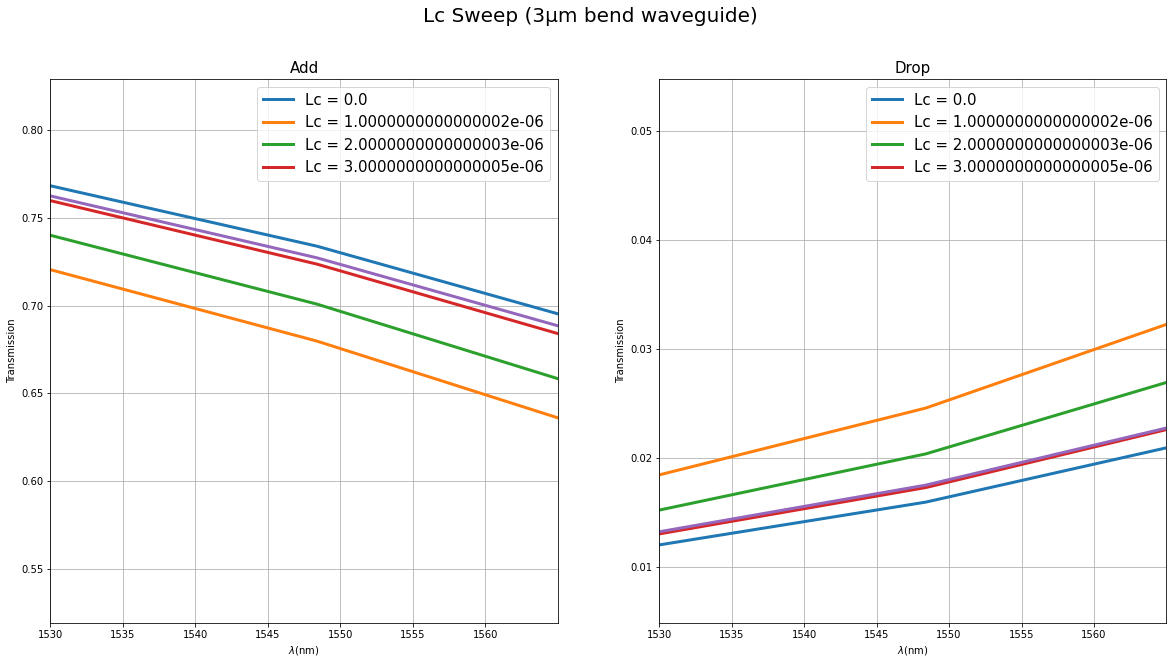

In [9]:
# Plots

figure15,fig = plt.subplots(1, 2, figsize=(20,10))

values = np.linspace(0, 5e-6, 6)
add = fdtd.getsweepresult('Lc Sweep3um', 'Port 2')
drop = fdtd.getsweepresult('Lc Sweep3um', 'Port 3')
wavelenght = add['lambda']
add = abs((add['T'])**2)
drop = np.transpose(abs((drop['T'])**2))
add = np.transpose(add)

for i in range(len(add)):
    aux = values[i]
    fig[0].set_xlim(Cband[0]*1e9,Cband[-1]*1e9)
    fig[0].set_ylabel("Transmission", fontsize = '10')
    fig[0].set_xlabel(r'$\lambda$(nm)', fontsize = '10')
    fig[0].set_xticks(np.arange(1530, 1565, step = 5), size = '10')
    fig[0].set_title('Add', size = 15)
    fig[0].legend(loc = 'upper right', prop = {'size': 15})
    fig[0].plot(wavelenght*1e9, add[i], label = 'Lc = ' + str(values[i]), linewidth = 3)

    fig[1].set_xlim(Cband[0]*1e9,Cband[-1]*1e9)
    fig[1].set_ylabel("Transmission", fontsize = '10')
    fig[1].set_xlabel(r'$\lambda$(nm)', fontsize = '10')
    fig[1].set_xticks(np.arange(1530, 1565, step = 5), size = '10')
    fig[1].set_title('Drop', size = 15)
    fig[1].legend(loc = 'upper right', prop = {'size': 15})
    fig[1].plot(wavelenght*1e9, drop[i], label = 'Lc = ' + str(values[i]), linewidth = 3)
    figure15.suptitle('Lc Sweep (3μm bend waveguide)', size = '20')

fig[0].grid()
fig[1].grid()

plt.savefig('figure15')


Lc Sweep with an bent waveguide 5μm

In [45]:
# Guide modifications for the sweep

bendr = 5e-6

fdtd.addrect()
fdtd.set({
  'name'     : 'Extension 1',
  'x min'    : r -(width/2) + lc/2,
  'x max'    : r +(width/2) + lc/2,
  'y max'    : 0,
  'y min'    : -r,
  'z min'    : 0,
  'z max'    : height,
  'material' : material,
})

fdtd.addrect()
fdtd.set({
  'name'     : 'Extension 2',
  'x min'    : -(r +(width/2) + lc/2),
  'x max'    : -(r -(width/2) + lc/2),
  'y max'    : 0,
  'y min'    : -r,
  'z min'    : 0,
  'z max'    : height,
  'material' : material,
})

fdtd.addrect()
fdtd.set({
  'name'     : 'Extension 3',
  'x min'    : bendr -(width/2) ,
  'x max'    : bendr +(width/2) ,
  'y max'    : bendr + 2*r + width + gap,
  'y min'    : bendr + r + width + gap,
  'z min'    : 0,
  'z max'    : height,
  'material' : material,
})

fdtd.addrect()
fdtd.set({
  'name'     : 'Extension 4',
  'x max'    : -(bendr -(width/2)),
  'x min'    : -(bendr +(width/2)),
  'y max'    : bendr + 2*r + width + gap,
  'y min'    : bendr + r + width + gap,
  'z min'    : 0,
  'z max'    : height,
  'material' : material,
})

fdtd.setnamed('Ring Resonator::outer_bottom',{'enabled' :  0})

fdtd.setnamed('Ring Resonator::arc2',{'enabled' :  0})

fdtd.setnamed('Ring Resonator::arc3',{'enabled' :  0})

fdtd.setnamed('FDTD', {
    'x'      : 0,
    'x span' : 4*r,
    'y'      : 1.5*r,
    'y span' : 4*r,
    'z'      : height/2,
})

fdtd.setnamed('Ring Resonator::outer_top', 'enabled', 0)

fdtd.addring()
fdtd.set({
'y'            : r + bendr + width + gap,
'z'            : height/2,
'z span'       : height,
'outer radius' :bendr +(width/2) ,
'inner radius' :bendr -(width/2) ,
'theta start'  : 180,
'theta stop'   : 360,
'material'     : material
})

fdtd.setnamed('FDTD::ports::port 1',{
  'y' : r + bendr + gap + width + 1e-6,
  'injection axis' : 'y-axis',
  'x' : -bendr,
  'direction' :'Backward',
  'x span' : 2e-6,
  'z' : height/2,
})

fdtd.setnamed('FDTD::ports::port 2',{
  'y' : (r + bendr + gap + width  + 1e-6),
  'injection axis' : 'y-axis',
  'x' : bendr,
  'x span' : 2e-6,
  'z' : height/2,
})

fdtd.setnamed('FDTD::ports::port 3',{
  'y' : -1e-6,
  'injection axis' : 'y-axis',
  'x' : r + lc/2,
  'x span' : 2e-6,
  'z' : height/2,
})

fdtd.setnamed('FDTD::ports::port 4',{'enabled' : 0})

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


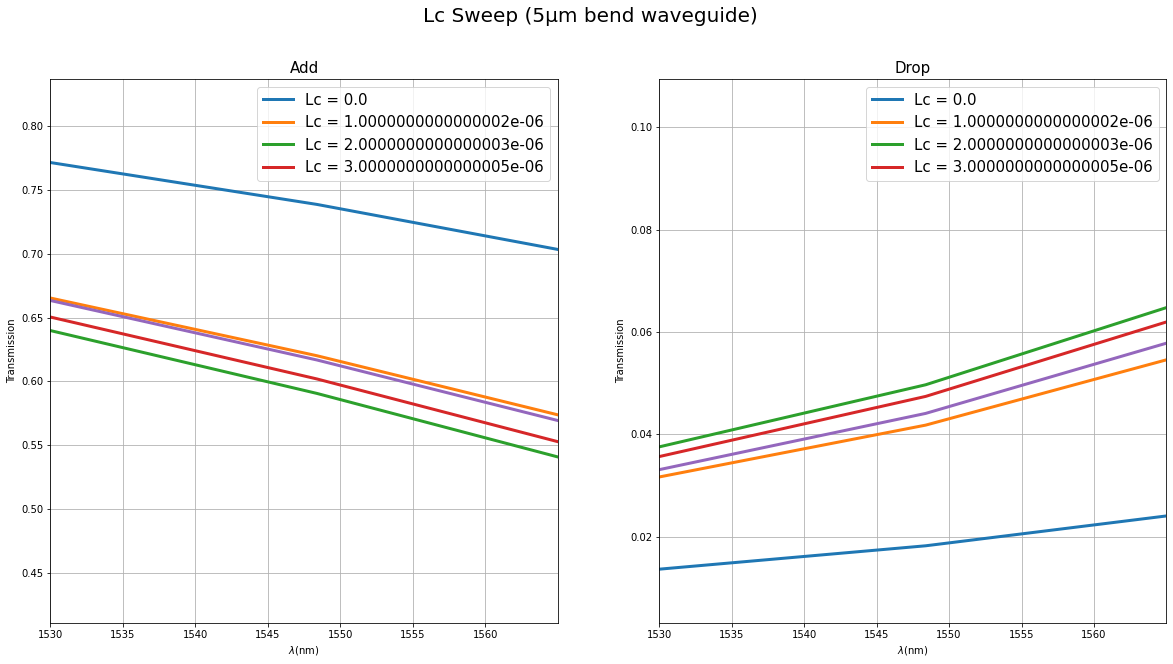

In [10]:
# Plots

figure16,fig = plt.subplots(1, 2, figsize=(20,10))

values = np.linspace(0, 5e-6, 6)
add = fdtd.getsweepresult('Lc Sweep5um', 'Port 2')
drop = fdtd.getsweepresult('Lc Sweep5um', 'Port 3')
wavelenght = add['lambda']
add = abs((add['T'])**2)
drop = np.transpose(abs((drop['T'])**2))
add = np.transpose(add)

for i in range(len(add)):
    fig[0].set_xlim(Cband[0]*1e9,Cband[-1]*1e9)
    fig[0].set_ylabel("Transmission", fontsize = '10')
    fig[0].set_xlabel(r'$\lambda$(nm)', fontsize = '10')
    fig[0].set_xticks(np.arange(1530, 1565, step = 5), size = '10')
    fig[0].set_title('Add', size = 15)
    fig[0].legend(loc = 'upper right', prop = {'size': 15})
    fig[0].plot(wavelenght*1e9, add[i], label = 'Lc = ' + str(values[i]), linewidth = 3)

    fig[1].set_xlim(Cband[0]*1e9,Cband[-1]*1e9)
    fig[1].set_ylabel("Transmission", fontsize = '10')
    fig[1].set_xlabel(r'$\lambda$(nm)', fontsize = '10')
    fig[1].set_xticks(np.arange(1530, 1565, step = 5), size = '10')
    fig[1].set_title('Drop', size = 15)
    fig[1].legend(loc = 'upper right', prop = {'size': 15})
    fig[1].plot(wavelenght*1e9, drop[i], label = 'Lc = ' + str(values[i]), linewidth = 3)
    figure16.suptitle('Lc Sweep (5μm bend waveguide)', size = '20')

fig[0].grid()
fig[1].grid()

plt.savefig('Lc Sweep (5μm bend waveguide)')


Gap Sweep


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


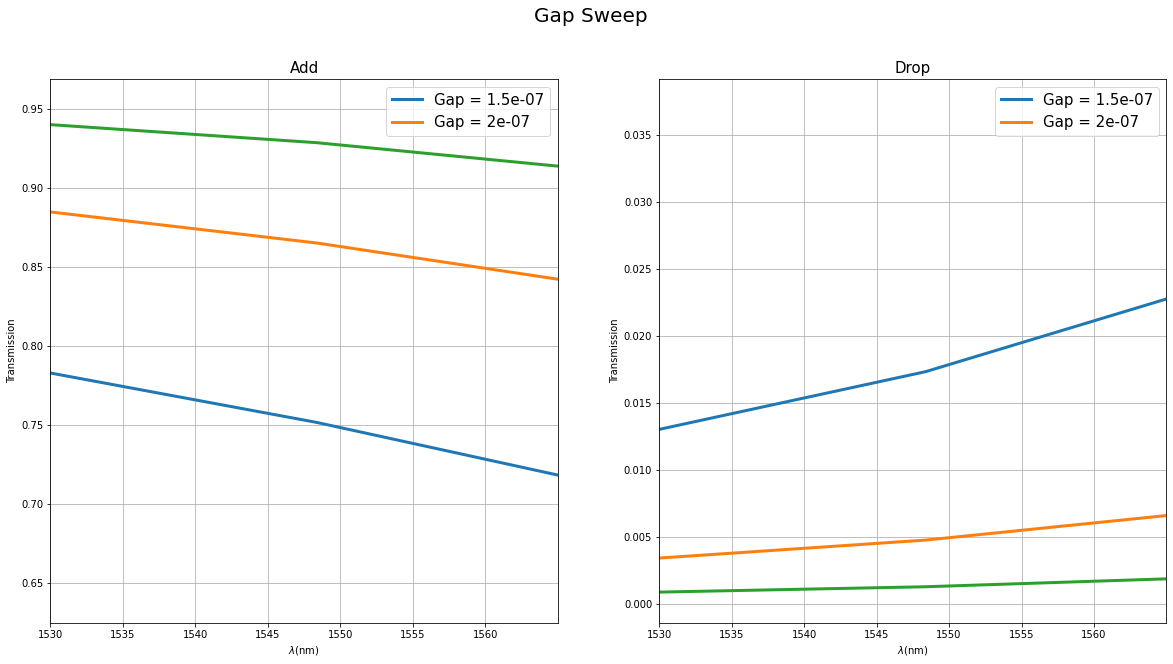

In [11]:
# Plots

figure17,fig = plt.subplots(1, 2, figsize=(20,10))

values = [150e-9, 200e-9, 250e-9]
add = fdtd.getsweepresult('Gap Sweep', 'Add')
drop = fdtd.getsweepresult('Gap Sweep', 'Drop')
wavelenght = add['lambda']
add = abs((add['T'])**2)
drop = np.transpose(abs((drop['T'])**2))
add = np.transpose(add)

for i in range(len(add)):
    fig[0].set_xlim(Cband[0]*1e9,Cband[-1]*1e9)
    fig[0].set_ylabel("Transmission", fontsize = '10')
    fig[0].set_xlabel(r'$\lambda$(nm)', fontsize = '10')
    fig[0].set_xticks(np.arange(1530, 1565, step = 5), size = '10')
    fig[0].set_title('Add', size = 15)
    fig[0].legend(loc = 'upper right', prop = {'size': 15})
    fig[0].plot(wavelenght*1e9, add[i], label = 'Gap = ' + str(values[i]), linewidth = 3)

    fig[1].set_xlim(Cband[0]*1e9,Cband[-1]*1e9)
    fig[1].set_ylabel("Transmission", fontsize = '10')
    fig[1].set_xlabel(r'$\lambda$(nm)', fontsize = '10')
    fig[1].set_xticks(np.arange(1530, 1565, step = 5), size = '10')
    fig[1].set_title('Drop', size = 15)
    fig[1].legend(loc = 'upper right', prop = {'size': 15})
    fig[1].plot(wavelenght*1e9, drop[i], label = 'Gap = ' + str(values[i]), linewidth = 3)
    figure17.suptitle('Gap Sweep', size = '20')

fig[0].grid()
fig[1].grid()

plt.savefig('Gap Sweep')

Gap and Lc Sweeps to INTERCONNECT Export

In [13]:
points = [[150e-9, 175e-9, 200e-9] # This are the points used to the simulations [Gap][Lc] Respectively
        , [0, 1.5e-6, 3e-6]]

In [60]:
#This cells will make the necessary sweeps for exporting the coupler to INTERCONNECT by diferent simulations with Lc and Gap changes

fdtd.setnamed('FDTD', 'y span', 10e-6)

# Lc = 0 with diferent gaps

for i in range(len(points)+1):
        fdtd.addsweep(3)
        fdtd.setsweep("s-parameter sweep", "name",str(int(points[0][i]*1e9)) + "nm Gap Sweep (Lc = 0)")
# Lc = 1.5μm with diferent gaps

for i in range(len(points)+1):
        fdtd.addsweep(3)
        fdtd.setsweep("s-parameter sweep", "name",str(int(points[0][i]*1e9)) + "nm Gap Sweep (Lc = 1,5μm)")

# Lc = 3μm with diferent gaps

for i in range(len(points)+1):
        fdtd.addsweep(3)
        fdtd.setsweep("s-parameter sweep", "name",str(int(points[0][i]*1e9)) + "nm Gap Sweep (Lc = 3μm)")
        

In [18]:
# Lc = 0

Lc = points[1]
gap = points[0]
r = 3e-6

for i in range(len(Lc)):
    fdtd.switchtolayout()
    fdtd.setnamed('Ring Resonator', {
        'lc' : Lc[0],
        'gap': gap[i]
    })
    fdtd.setnamed('FDTD::ports::port 1',{'y' : Lc[0] + gap[i] + r + width})
    fdtd.setnamed('FDTD::ports::port 2',{'y' : Lc[0] + gap[i] + r + width})
    fdtd.setnamed('FDTD::ports::port 3',{'x' : -(r + Lc[0]/2)})
    fdtd.setnamed('Extension 1',{'x' : -(r + Lc[0]/2)} )
    fdtd.setnamed('FDTD::ports::port 4',{'x' : r + Lc[0]/2, 'enabled' : 1})
    fdtd.setnamed('Extension 2',{'x' : (r + Lc[0]/2)} )
    fdtd.runsweep(str(int(gap[i]*1e9)) + "nm Gap Sweep (Lc = 0)")

In [ ]:
# Lc = 1.5μm

Lc = points[1]
gap = points[0]
r = 3e-6

for i in range(len(Lc)):
    fdtd.switchtolayout()
    fdtd.setnamed('Ring Resonator', {
        'lc' : Lc[1],
        'gap': gap[i]
    })
    fdtd.setnamed('FDTD::ports::port 1',{'y' : gap[i] + r + width})
    fdtd.setnamed('FDTD::ports::port 2',{'y' : gap[i] + r + width})
    fdtd.setnamed('FDTD::ports::port 3',{'x' : -(r + Lc[1]/2)})
    fdtd.setnamed('Extension 1',{'x' : -(r + Lc[1]/2)} )
    fdtd.setnamed('FDTD::ports::port 4',{'x' : r + Lc[1]/2, 'enabled' : 1})
    fdtd.setnamed('Extension 2',{'x' : (r + Lc[1]/2)} )
    fdtd.runsweep(str(int(gap[i]*1e9)) + "nm Gap Sweep (Lc = 1,5μm)")

In [64]:
# Lc = 3μm

Lc = points[1]
gap = points[0]
r = 3e-6

for i in range(len(Lc)):
    fdtd.switchtolayout()
    fdtd.setnamed('Ring Resonator', {
        'lc' : Lc[2],
        'gap': gap[i]
    })
    fdtd.setnamed('FDTD::ports::port 1',{'y' : gap[i] + r + width})
    fdtd.setnamed('FDTD::ports::port 2',{'y' : gap[i] + r + width})
    fdtd.setnamed('FDTD::ports::port 3',{'x' : -(r + Lc[2]/2)})
    fdtd.setnamed('Extension 1',{'x' : -(r + Lc[2]/2)} )
    fdtd.setnamed('FDTD::ports::port 4',{'x' : r + Lc[2]/2, 'enabled' : 1})
    fdtd.setnamed('Extension 2',{'x' : (r + Lc[2]/2)} )
    fdtd.runsweep(str(int(gap[i]*1e9)) + "nm Gap Sweep (Lc = 3μm)")

# Lumerical Interconnect

In [10]:
icp = lumapi.INTERCONNECT(filename = 'Ring_Resonator_INTERCONNECT.icp')

In [7]:
icp.layoutmode()
icp.deleteall()

In [ ]:
icp.addelement("Optical Network Analyzer")
icp.set("name", "ONA_1")
icp.set("number of input ports", 4)
icp.set("input parameter", "start and stop")
icp.set("start frequency", c0/Cband[0])
icp.set("stop frequency", c0/Cband[-1])
icp.set("number of points", 5e5)

In [9]:
icp.addelement('Optical N Port S-parameter')
icp.set("load from file", True)